In [56]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import genfromtxt

sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu

In [57]:
MASK_OUT = -1
# compute mse per cluster and then average over batch or file
def mse_batch(labels, preds):
    return np.mean(np.mean(np.square(labels - preds), axis=1))

def mse_batch_no_pad(preds, labels):
    sum = 0
    count = 0
    for clus_idx, clus_labels in enumerate(labels):
        cut_padding = (clus_labels != MASK_OUT)
        if len(clus_labels[cut_padding]) > 0:
            sum += np.mean(np.square(clus_labels[cut_padding] - preds[clus_idx][cut_padding]))
            count += 1

    return sum / count

# slice and plot loss
def plot_batch_loss(all_loss, batch_low=None, batch_high=None):
    batch_high = len(all_loss) if batch_high == None else batch_high
    batch_low = 0 if batch_low == None else batch_low
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(batch_low, batch_high), all_loss[batch_low:batch_high])
    plt.xlabel("batch")
    plt.ylabel("loss")
    plt.show()

def plot_epoch_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="train")
    plt.plot(val_loss, label="val")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Mean squared error loss")
    plt.legend()
    plt.show()

def get_history(file_name):
    return np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/" + file_name, allow_pickle=True)

def plot_clus_pred_acc(clus_idx, preds, labels, verbose=False, point_low=None, point_high=None):
    if point_low == None and point_high == None:
        point_low = 0
        point_high = len(labels[clus_idx][cut_padding]) + 10
    cut_padding = labels[clus_idx] != MASK_OUT
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
    plt.scatter(np.arange(point_low, point_high), preds[clus_idx][point_low:point_high], label="preds")
    plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][cut_padding]), point_high - point_low), color="grey")
    plt.xlabel("point")
    plt.ylabel("EM frac")
    plt.title("Cluster " + str(clus_idx))
    plt.legend()
    plt.show()
    if verbose:
        print("cluster" + str(clus_idx) + ", cells " + str(point_low) + " to " + point_high)
        print("predicted EM frac:")
        print(preds[clus_idx][point_low:point_high].flatten())
        print("truth:")
        print(labels[clus_idx][point_low:point_high].flatten())

def plot_clus_preds_acc(clus_idxs, preds, labels, epochs, verbose=False, point_low=None, point_high=None):
    calc_range = False
    if point_low == None and point_high == None:
        calc_range = True
    
    for clus_idx in clus_idxs:
        cut_padding = labels[clus_idx] != MASK_OUT
        if calc_range:
            point_low = 0
            point_high = min(len(labels[clus_idx][cut_padding]) + 10, len(labels[clus_idx]))
        fig = plt.figure(figsize=(15,3))
        fig.patch.set_facecolor('white')
        plt.scatter(np.arange(point_low, point_high), labels[clus_idx][point_low:point_high], label="truth")
        for epoch in epochs:
            plt.scatter(np.arange(point_low, point_high), preds[epoch][clus_idx][point_low:point_high], label="epoch " + str(epoch))
        plt.plot(np.arange(point_low, point_high), np.repeat(np.mean(labels[clus_idx][cut_padding]), point_high - point_low), color="grey")
        plt.xlabel("point")
        plt.ylabel("EM frac")
        plt.title("Cluster " + str(clus_idx) + " preds")
        plt.legend()
        plt.show()

    # plot hist of all clusters
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    cut_padding_all_clus = labels != MASK_OUT
    data = [labels[cut_padding_all_clus].flatten()]
    labels = ["truth"]
    for epoch in epochs:
        data.append(preds[epoch][cut_padding_all_clus].flatten())
        labels.append("epoch " + str(epoch))

    pu.plot_overlay_hist(data, 75, "All clusters predictions", "EM frac", "frequency", labels)

def plot_all_clus_acc(history):
    cut_padding = (history["labels"] != -1)
    all_labels = history["labels"][cut_padding].flatten()
    all_preds = history["preds"][cut_padding].flatten()
    pu.plot_overlay_hist([all_labels, all_preds], 100, "All clusters", "EM frac", "frequency", ["truth", "preds"])
    
def pointwise_loss_func(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = np.equal(y_true, MASK_OUT)
    mask = 1 - mask

    # multiply mse with the mask
    loss = np.square(y_true - y_pred) * mask

    # take average w.r.t. the number of unmasked entries
    out = np.sum(loss) / np.sum(mask) # flattens data
    return out

def batch_wise_loss_func(y_true, y_pred):
    # find out which timesteps in `y_true` are not the padding character '#'
    mask = np.equal(y_true, MASK_OUT)
    mask = 1 - mask

    # multiply mse with the mask
    loss = np.square(y_true - y_pred) * mask

    # take average w.r.t. the number of unmasked entries
    out = np.sum(loss, axis=1) / np.sum(mask, axis=1) # flattens data
    return np.mean(out)

In [181]:
# compare Russell's different models

# gamma
def get_model_data(name):
    # with Masking layer applied at beggining
    history = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_6_files_" + name + ".npz", allow_pickle=True)

    # compute mse for points that are not masked out
    print("mse", np.mean(np.square(history["labels"] - history["preds"])))
    print(history["preds"][0][:20].flatten())
    print(history["labels"][0][:20].flatten())

get_model_data("gamma") # sets all values to 1
get_model_data("omicron")
get_model_data("delta")

# TODO: determine why are these all identical??

mse 0.9376966450361149
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.30507627 1.         0.79853743 0.12058365 0.99844193 0.96814859
 0.99958527 1.         0.31151381 0.5953508  1.         0.86264044
 0.8490988  0.         0.         0.         0.         0.
 0.         0.        ]
mse 0.9376966450361149
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.30507627 1.         0.79853743 0.12058365 0.99844193 0.96814859
 0.99958527 1.         0.31151381 0.5953508  1.         0.86264044
 0.8490988  0.         0.         0.         0.         0.
 0.         0.        ]
mse 0.9376966450361149
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.30507627 1.         0.79853743 0.12058365 0.99844193 0.96814859
 0.99958527 1.         0.31151381 0.5953508  1.         0.86264044
 0.8490988  0.         0.         0.         0.         0.
 0.         0.        ]


history_6_files_gamma.npz
mse (all data) = 0.9376966450361145


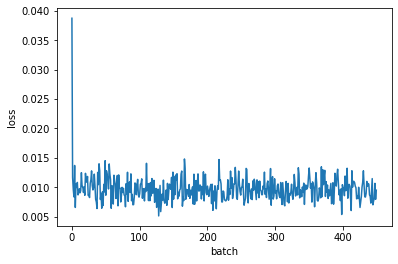

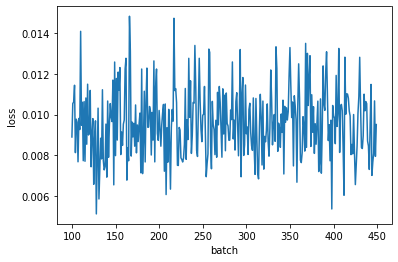

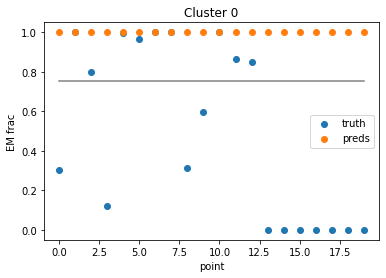

history_6_files_gamma_no_mask.npz
mse (all data) = 0.04996181434974635


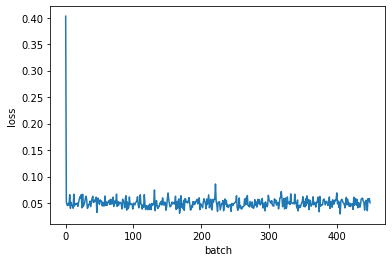

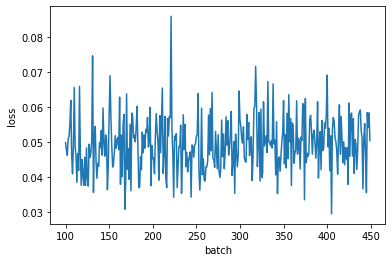

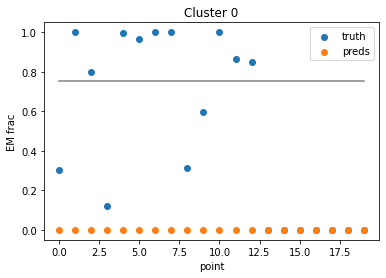

history_6_files_gamma_no_mask_plus_regularization.npz
mse (all data) = 0.04996181434974635


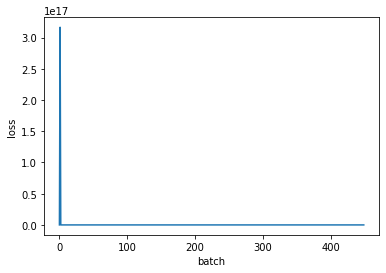

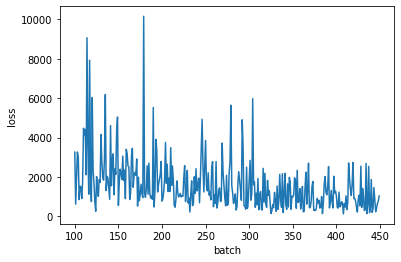

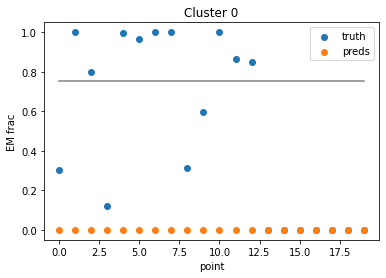

history_6_files_gamma_no_mask_plus_regualrization_no_x_shape.npz
mse (all data) = 0.04996181434974635


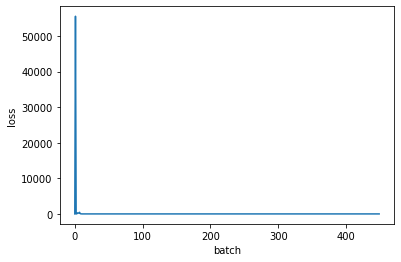

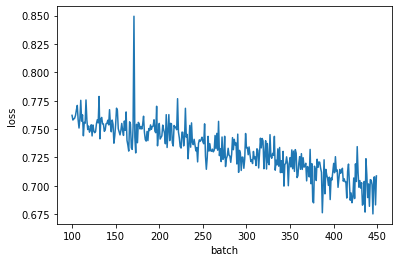

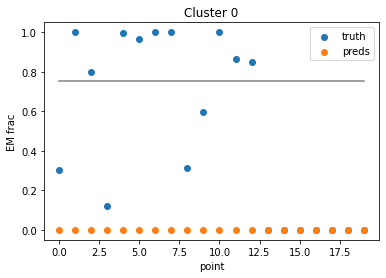

In [182]:
# gamma w/out masking
def get_model_label_data(file_name):
    print(file_name)
    history = get_history(file_name)
    print("mse (all data) =", mse_batch(history["preds"], history["labels"]))
    
    plot_batch_loss(history["loss"])
    plot_batch_loss(history["loss"], 100)
    plot_clus_pred_acc(0, history)

get_model_label_data("history_6_files_gamma.npz")
get_model_label_data("history_6_files_gamma_no_mask.npz")
get_model_label_data("history_6_files_gamma_no_mask_plus_regularization.npz")
get_model_label_data("history_6_files_gamma_no_mask_plus_regualrization_no_x_shape.npz")

history_segmentation_150_files_5_epochs_64_batch_size.npz:


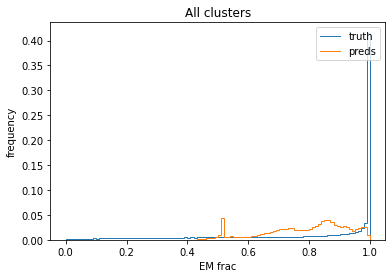

mse: 0.0042705475835245425


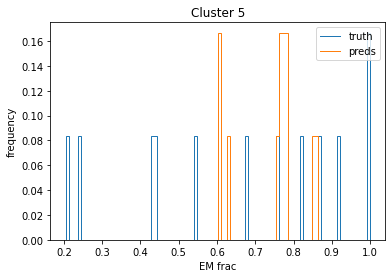

mse (no padding): 0.0989364358948025


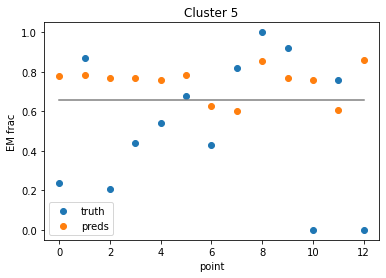

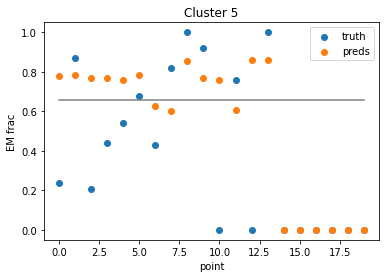

history_segmentation_50_files_25_epochs_64_batch_size.npz:


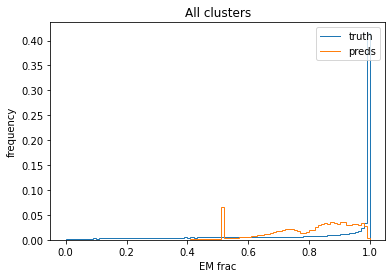

mse: 0.004195212506803577


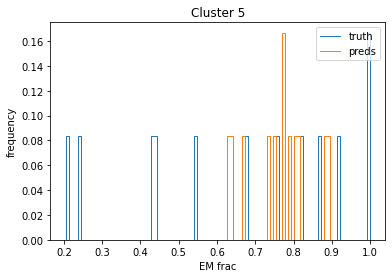

mse (no padding): 0.10017558386340758


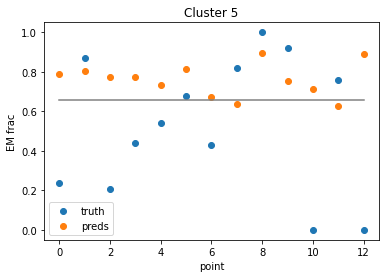

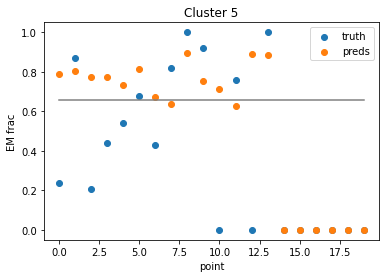

In [28]:
def visualize_pred_accuracy(file_name, cluster_idx, verbose=False):
    print(file_name + ":")
    history = get_history(file_name)
    true_points_cut = (history["labels"][cluster_idx] != 0)
    labels = history["labels"][cluster_idx][true_points_cut].flatten()
    preds = history["preds"][cluster_idx][true_points_cut].flatten()

    plot_all_clus_acc(history)

    print("mse:", mse_batch(history["preds"], history["labels"]))
    pu.plot_overlay_hist([labels, preds], 100, "Cluster " + str(cluster_idx), "EM frac", "frequency", ["truth", "preds"])
    print("mse (no padding):", mse_batch_no_pad(history["preds"], history["labels"]))
   

    plot_clus_pred_acc(cluster_idx, history, verbose, 0, 13)
    plot_clus_pred_acc(cluster_idx, history, verbose, 0, 20)

visualize_pred_accuracy("history_segmentation_150_files_5_epochs_64_batch_size.npz", 5)
visualize_pred_accuracy("history_segmentation_50_files_25_epochs_64_batch_size.npz", 5)
    

history_segmentation_150_files_5_epochs_64_batch_size.npz
mse (all data) = 0.0042705475835245425


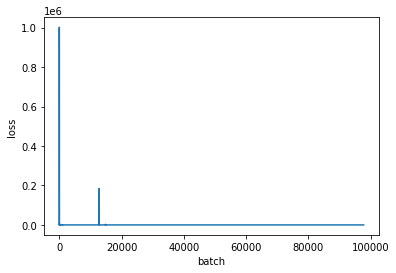

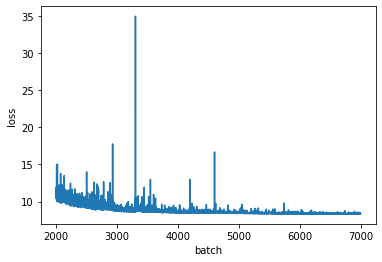

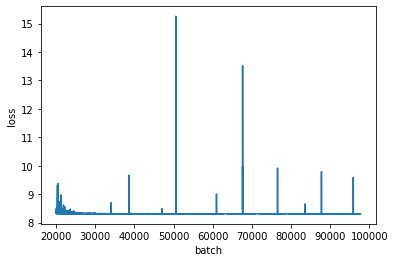

history_segmentation_50_files_25_epochs_64_batch_size.npz
mse (all data) = 0.004195212506803577


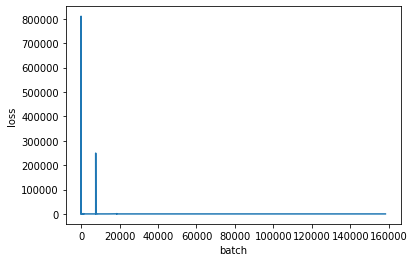

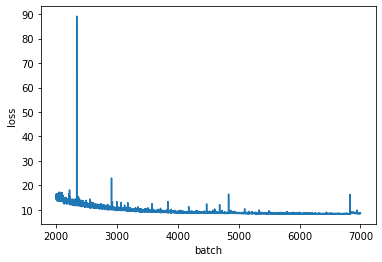

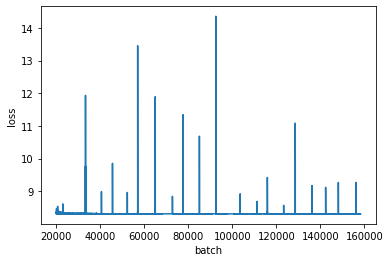

In [184]:
# generic point cloud testing:
def get_performance_data(file_name, cuts=[[None, None]]):
    print(file_name)
    history = get_history(file_name)
    print("mse (all data) =", mse_batch(history["labels"], history["preds"]))
    for cut in cuts:
        plot_batch_loss(history["loss"], cut[0], cut[1])
    
    
#get_performance_data("test_5_epochs.npz") # 6 files, generic segmentation model
cuts = [[None, None], [2000, 7000], [20000, None]]
get_performance_data("history_segmentation_150_files_5_epochs_64_batch_size.npz", cuts)
get_performance_data("history_segmentation_50_files_25_epochs_64_batch_size.npz", cuts)

# NOTE:
#   - with 150 files, 5 epochs - converges around batch 6000
#   - mse = 0.00427 (including padding), mse = 0.0797 (no padding)
#   - with 50 files, 25 epochs - converges around batch 5000
#   - mse = 0.004195 (including padding), mse = 0.0798(no padding)

history_mask_testing_25_files_no_mask.npz
mse (all data) = 0.005993274268118932


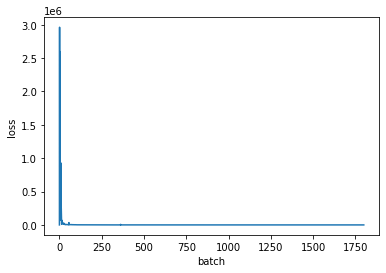

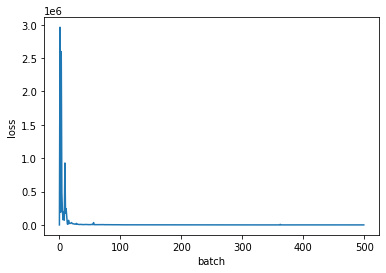

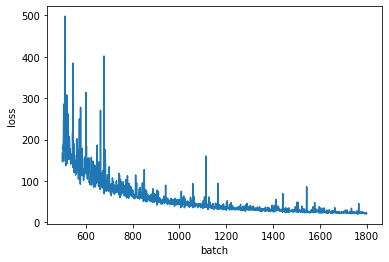

history_mask_testing_25_files_no_mask.npz:
mse = 0.11924449527385583


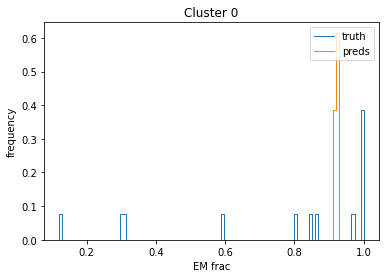

mse (no padding)= 0.07123781736474179


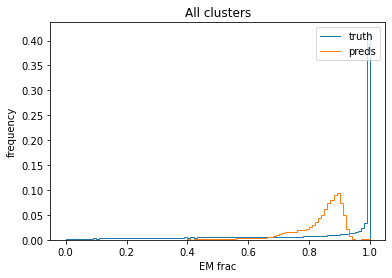

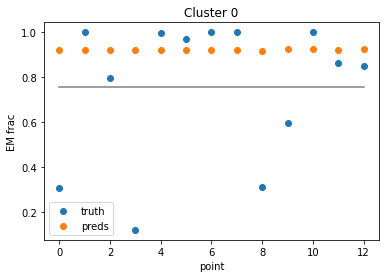

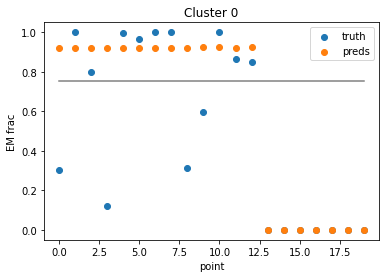

history_mask_testing_25_files_mask.npz
mse (all data) = 0.005890698944959698


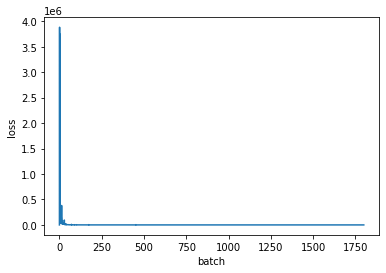

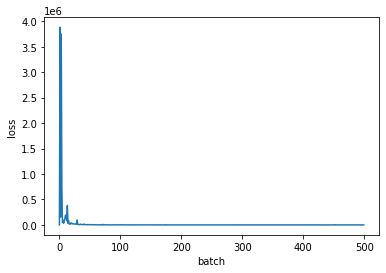

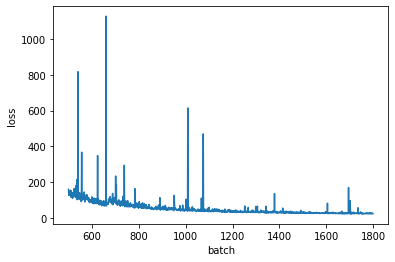

history_mask_testing_25_files_mask.npz:
mse = 0.11034968724625831


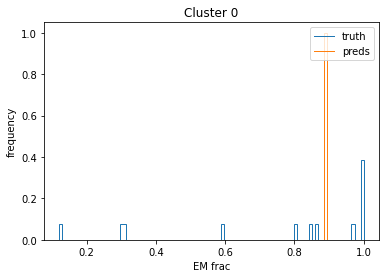

mse (no padding)= 0.07102010309810415


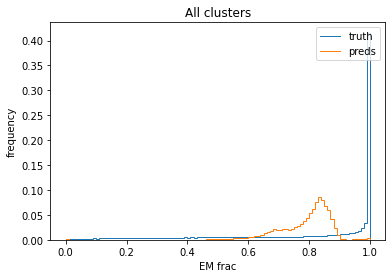

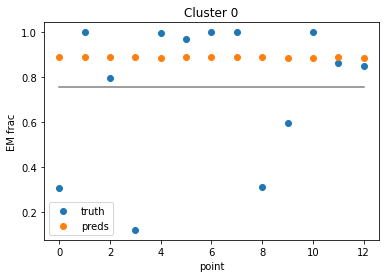

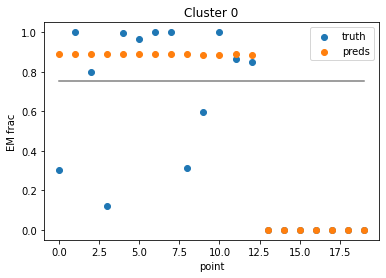

In [185]:
# masked output testing - on generic PointNet segmentation
# with Masking layer applied at beggining
cuts = [[None, None], [None, 500], [500, None]]
files = ["history_mask_testing_25_files_no_mask.npz", "history_mask_testing_25_files_mask.npz"]

for file in files:
    get_performance_data(file, cuts)
    visualize_pred_accuracy(file, 0)



history_segmentation_6_files_no_mask.npz
mse (all data) = 0.005839135688332028


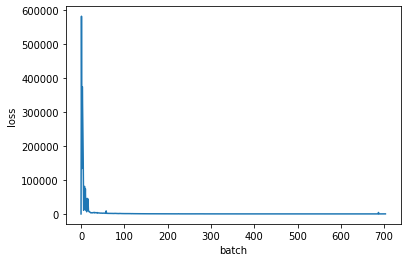

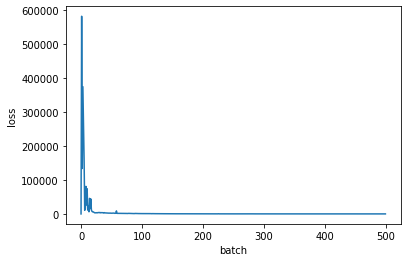

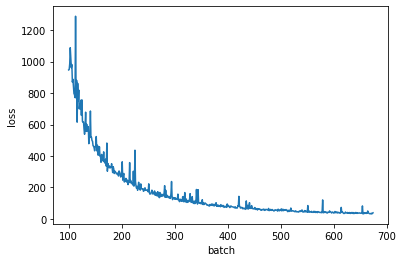

history_segmentation_6_files_no_mask.npz:
mse = 0.09609100603789268


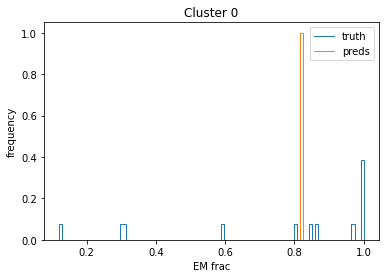

mse (no padding)= 0.08191830294518412


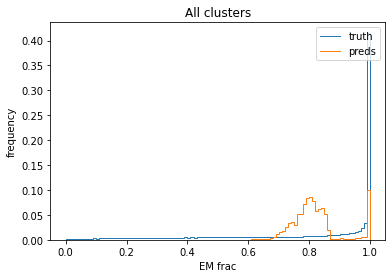

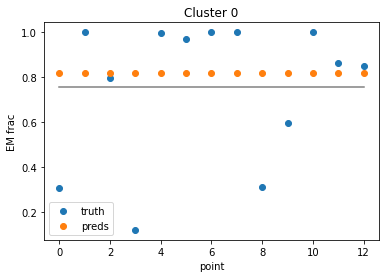

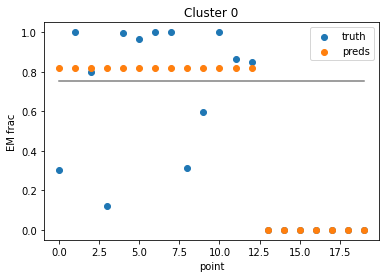

history_segmentation_6_files_mask_propagate.npz
mse (all data) = 0.7235388236094024


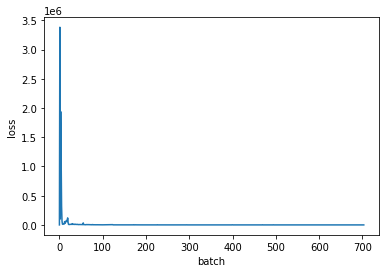

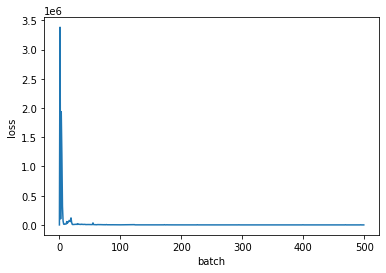

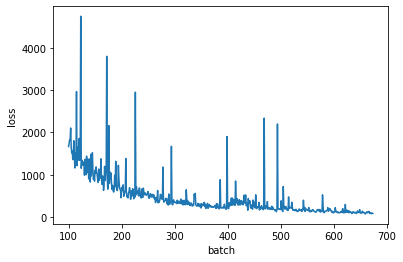

history_segmentation_6_files_mask_propagate.npz:
mse = 0.09846077474614266


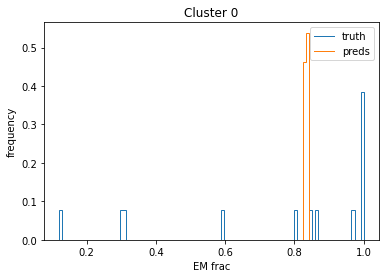

mse (no padding)= 0.07667222698145336


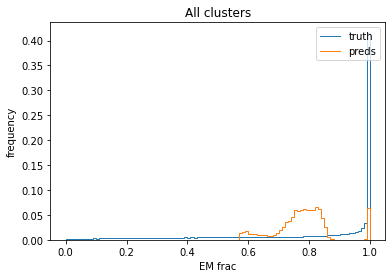

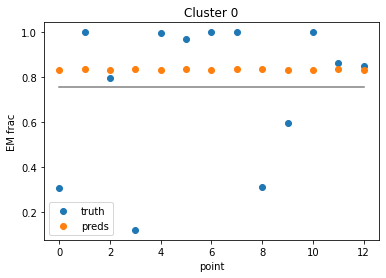

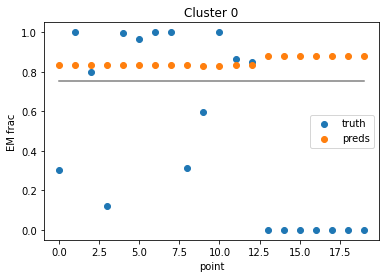

history_segmentation_6_files_mask_propagate_dont_pass.npz
mse (all data) = 0.005864911057332612


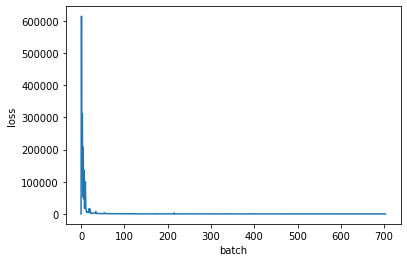

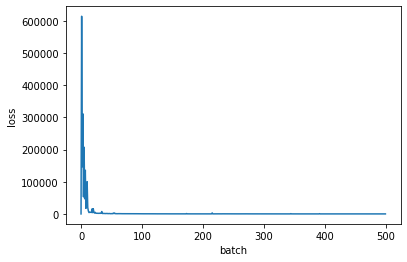

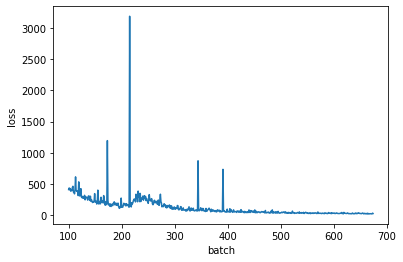

history_segmentation_6_files_mask_propagate_dont_pass.npz:
mse = 0.09775571616368389


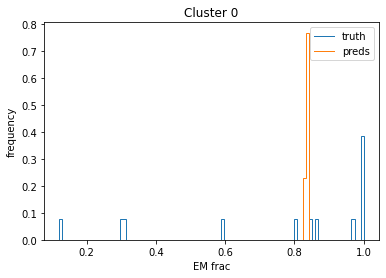

mse (no padding)= 0.08189351126950062


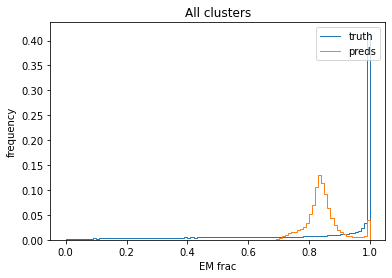

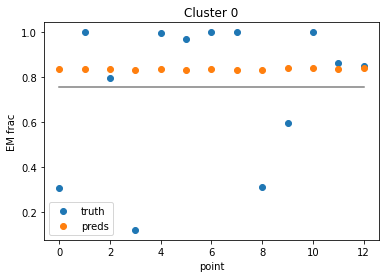

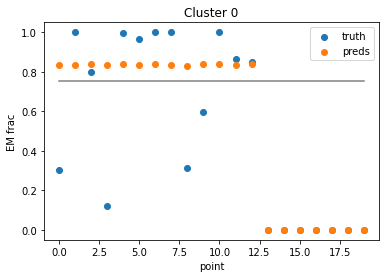

history_segmentation_25_files_mask_propagate.npz
mse (all data) = 0.784332076155283


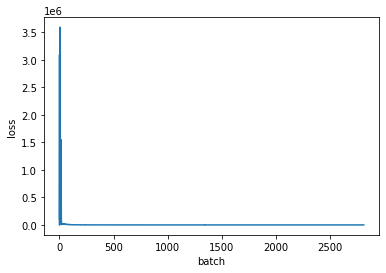

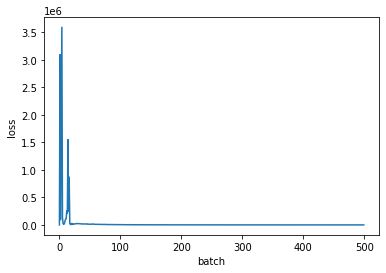

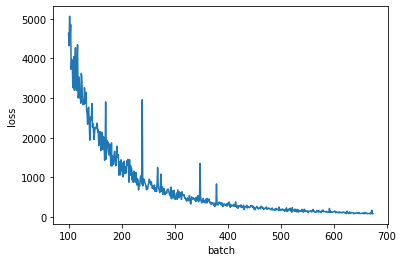

history_segmentation_25_files_mask_propagate.npz:
mse = 0.12069400382562456


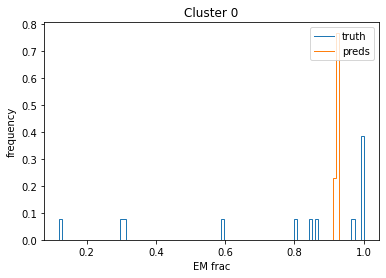

mse (no padding)= 0.07408549235099739


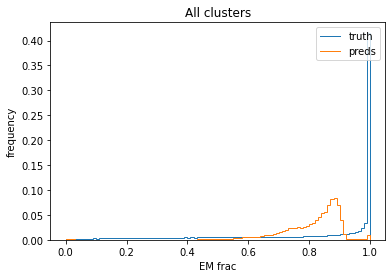

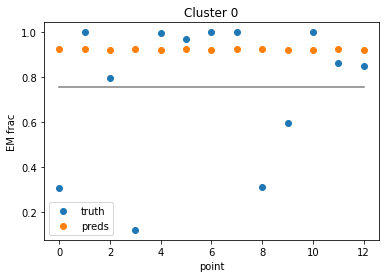

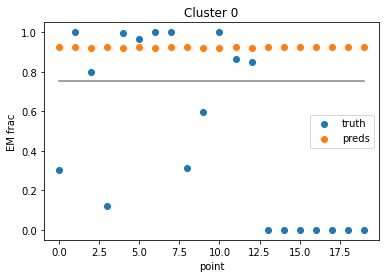

history_segmentation_25_files_5_epochs_mask_propagate.npz
mse (all data) = 0.6769141705437657


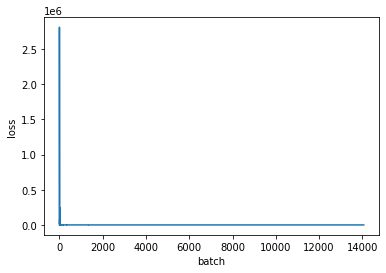

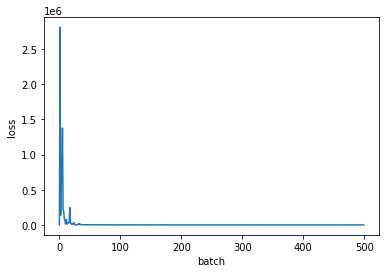

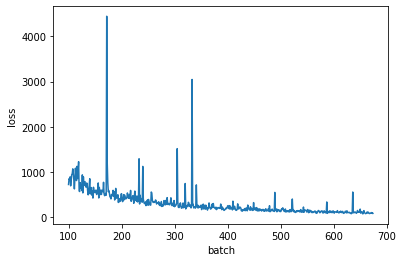

history_segmentation_25_files_5_epochs_mask_propagate.npz:
mse = 0.1093984891180627


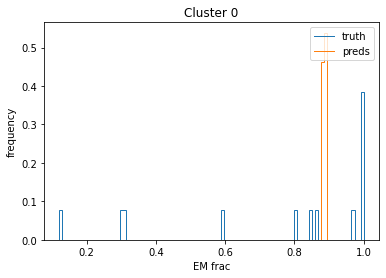

mse (no padding)= 0.070827716288616


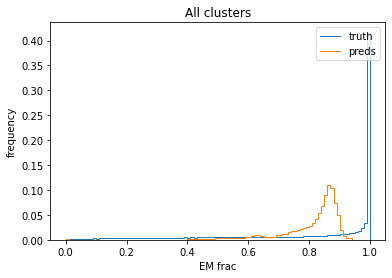

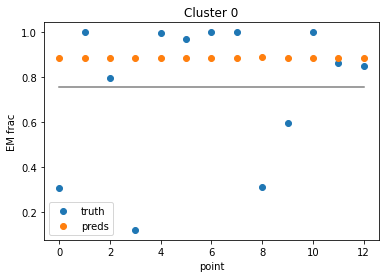

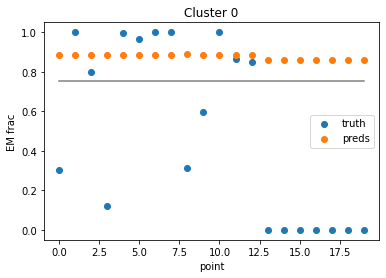

In [186]:
# masked output testing - on generic PointNet segmentation
# with Masking layer applied at beggining
cuts = [[None, None], [None, 500], [100, 675]]
files = ["history_segmentation_6_files_no_mask.npz", "history_segmentation_6_files_mask_propagate.npz", "history_segmentation_6_files_mask_propagate_dont_pass.npz", "history_segmentation_25_files_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate.npz"]

for file in files:
    get_performance_data(file, cuts)
    visualize_pred_accuracy(file, 0)

# NOTE: cast to zeros was not included in tNet :( for "history_segmentation_6_files_mask_propagate.npz", "history_segmentation_6_files_mask_propagate_dont_pass.npz",
#  "history_segmentation_25_files_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate.npz"


history_segmentation_25_files_5_epochs_mask_propagate.npz
mse (all points): 0.6769141705437657
mse (no pad): 0.12093946527600946


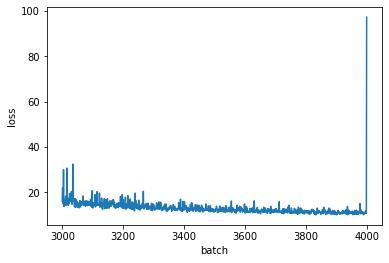

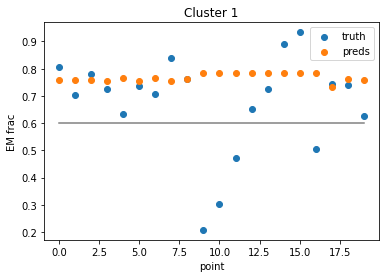

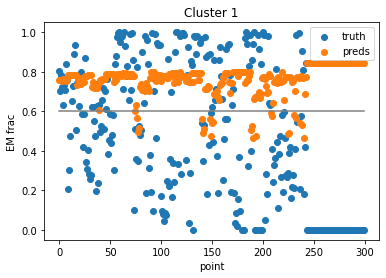

history_segmentation_25_files_5_epochs_mask_propagate_fix.npz
mse (all points): 0.7290882513907863
mse (no pad): 0.11902427489746022


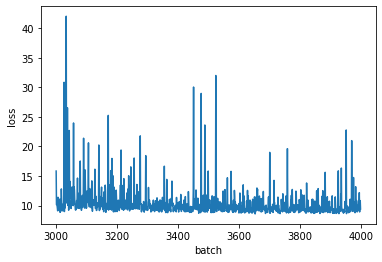

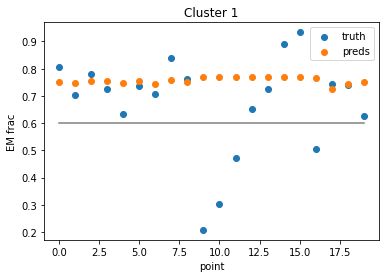

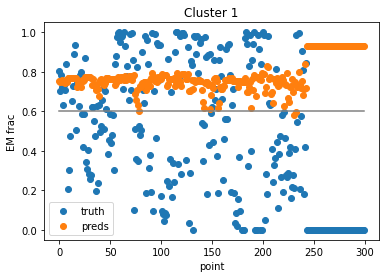

In [187]:
files = ["history_segmentation_25_files_5_epochs_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate_fix.npz"] #["history_segmentation_25_files_no_mask.npz", "history_segmentation_25_files_mask_propagate.npz", "history_segmentation_25_files_mask_propagate_fix.npz", "history_segmentation_25_files_5_epochs_mask_propagate.npz", "history_segmentation_25_files_5_epochs_mask_propagate_fix.npz"]#"history_gamma_6_files_BN.npz"]

for file in files:
    print(file)
    history = get_history(file)
    cluster_idx = 1

    print("mse (all points):", mse_batch(history["preds"], history["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history["preds"], history["labels"]))
   
    plot_batch_loss(history["loss"], 3000, 4000)
    plot_clus_pred_acc(cluster_idx, history, 0, 20)
    plot_clus_pred_acc(cluster_idx, history, 0, 300)



history_gamma_25_files_BN.npz
mse (all points): 0.6726411147325013
mse (no pad): 0.11333598596038362


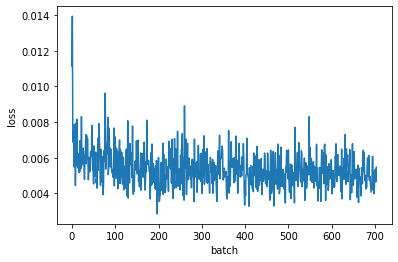

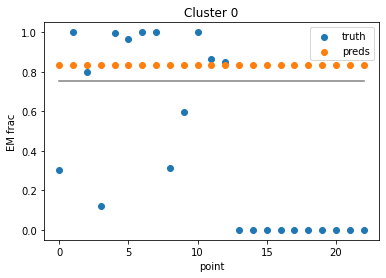

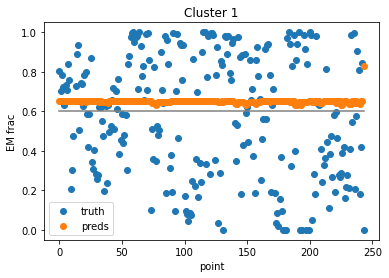

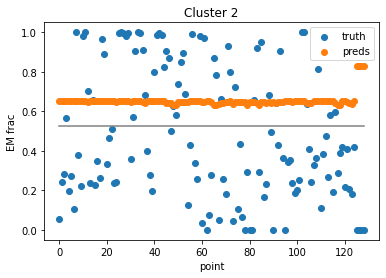

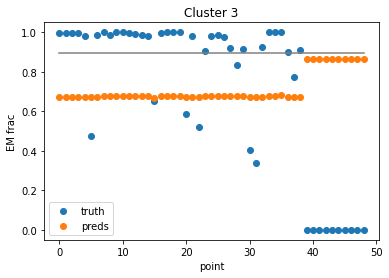

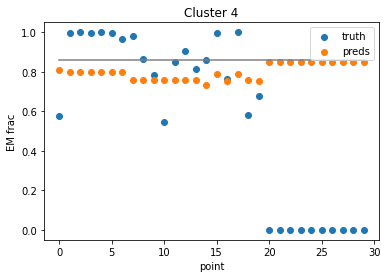

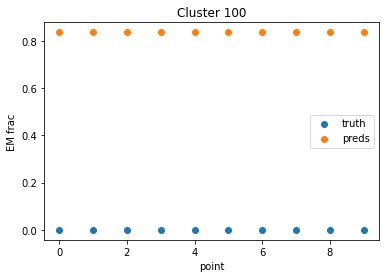

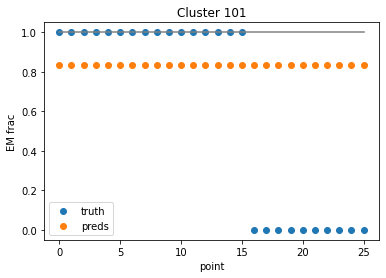

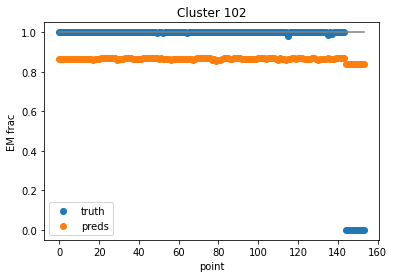

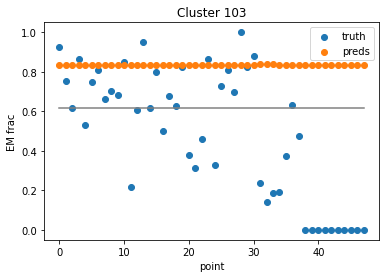

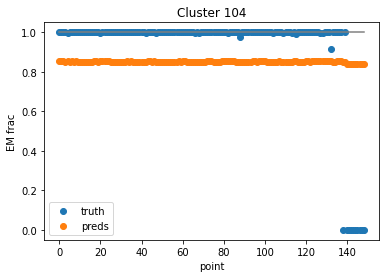

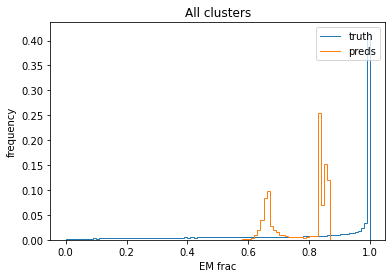

history_gamma_150_files_5_epochs_BN_cartesian.npz
mse (all points): 0.6867769605167843
mse (no pad): 0.08603569697404354


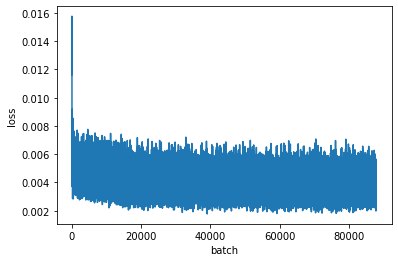

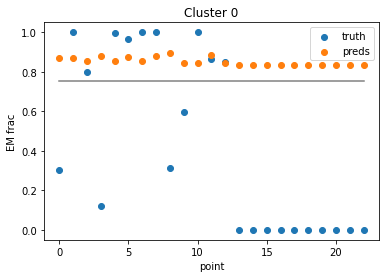

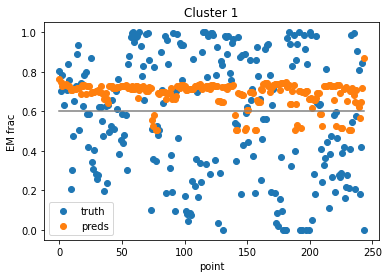

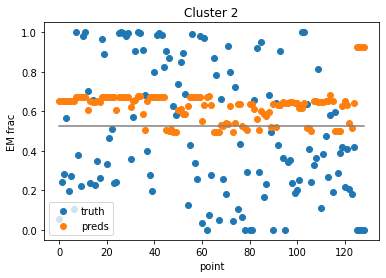

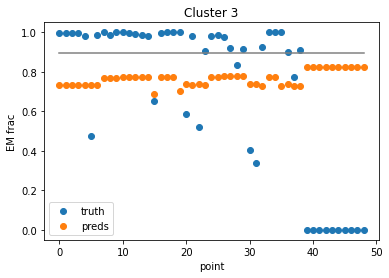

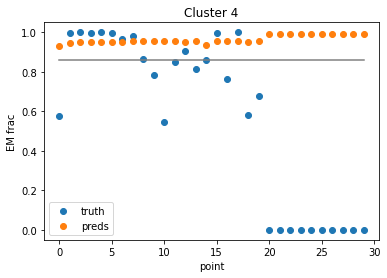

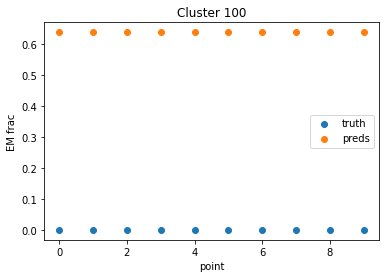

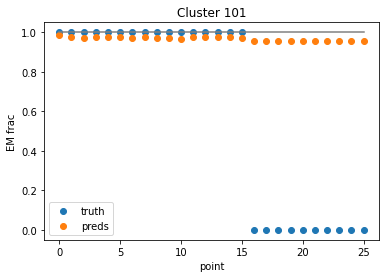

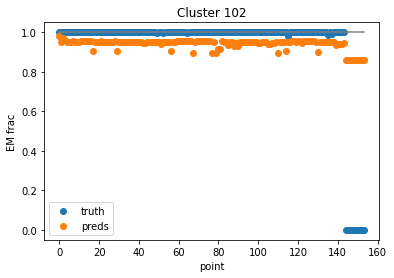

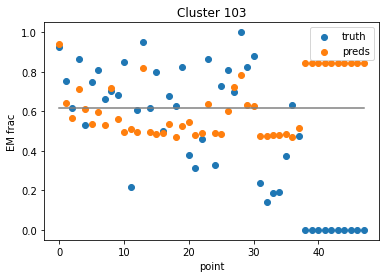

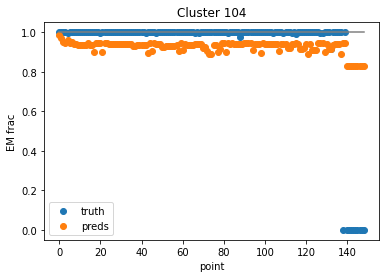

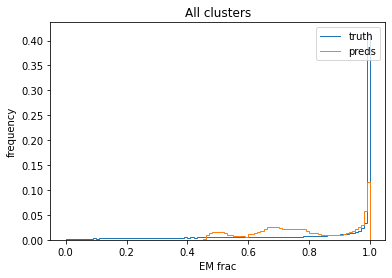

In [26]:
files = ["history_gamma_25_files_BN.npz", "history_gamma_150_files_5_epochs_BN_cartesian.npz"] # "/history_gamma_1_tr_3_tst_1_val_1_epoch_BN_cartesian.npz"

for file in files:
    print(file)
    history = get_history(file)
    cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104]

    print("mse (all points):", mse_batch(history["preds"], history["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history["preds"], history["labels"]))

    plot_batch_loss(history["loss"])
    for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history)

    plot_all_clus_acc(history)

history_gamma_325_tr_40_tst_40_val_5_epoch_BN_cartesian.npz
got preds
got labels


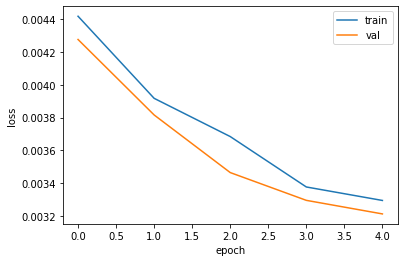

mse (all points): 0.6112571345825302
mse (no pad): 0.06986874978789445


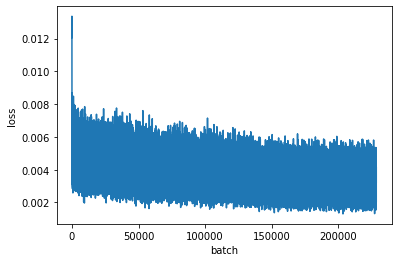

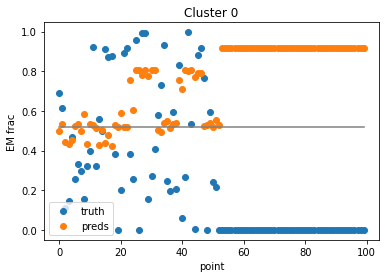

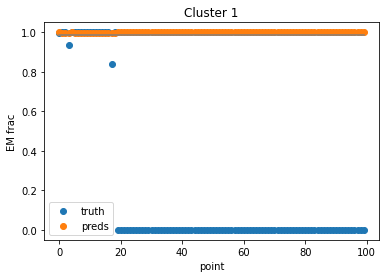

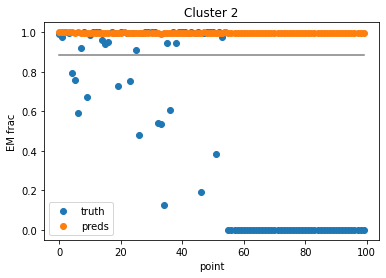

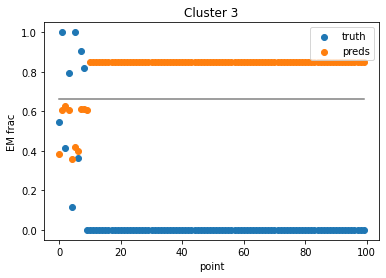

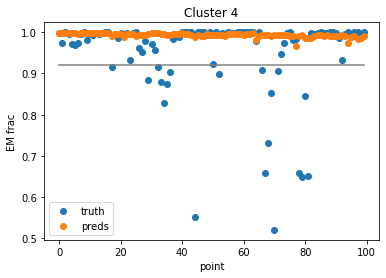

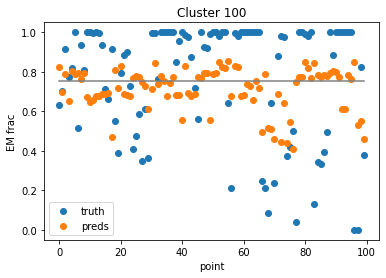

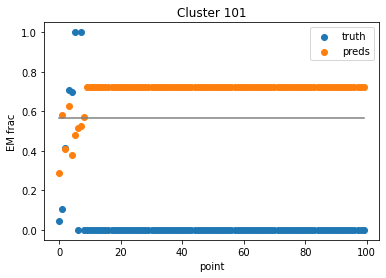

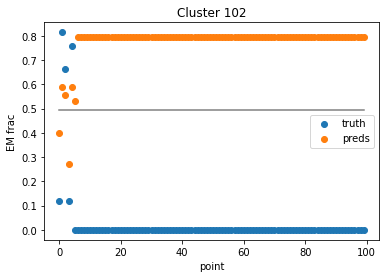

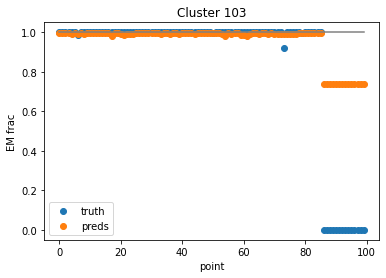

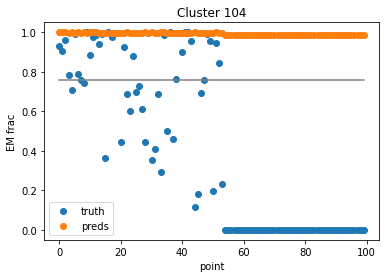

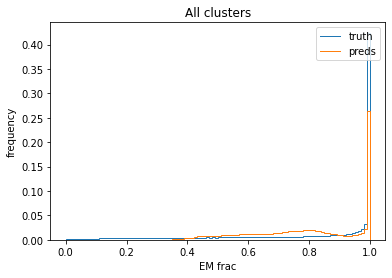

In [56]:
files = ["history_gamma_325_tr_40_tst_40_val_5_epoch_BN_cartesian.npz"]

for file in files:
    print(file)
    history = get_history(file)
    preds = history["preds"][:9000] # 10 s
    print("got preds")   
    labels = history["labels"][:9000]
    print("got labels")    
    #print(history["preds"].shape) # takes 3m to get shape ??

    plot_epoch_loss(history["history"].item())
    #cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104]
    history_subset = {
        "preds": preds,
        "labels": labels,
    }
    print("mse (all points):", mse_batch(history_subset["preds"], history_subset["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history_subset["preds"], history_subset["labels"]))

    plot_batch_loss(history["loss"])
    for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history_subset, False, 0, 100)

    plot_all_clus_acc(history_subset)

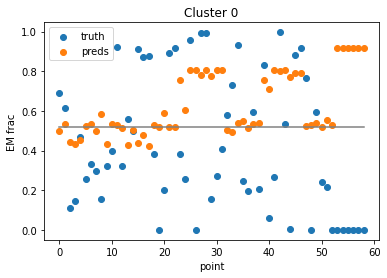

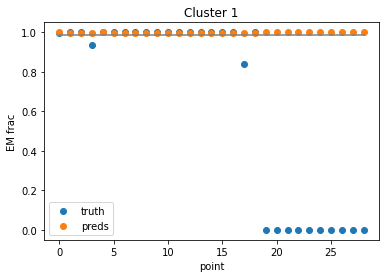

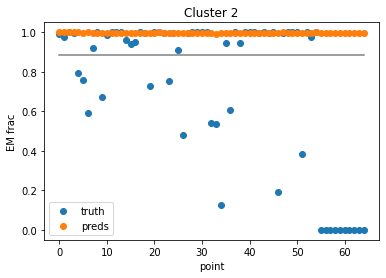

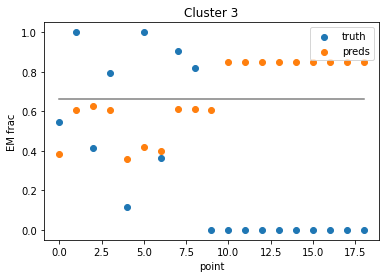

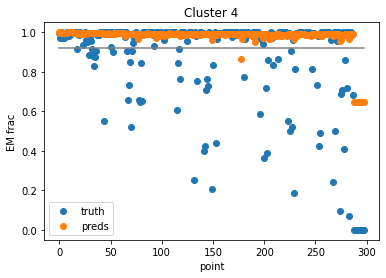

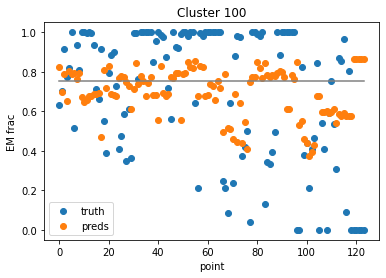

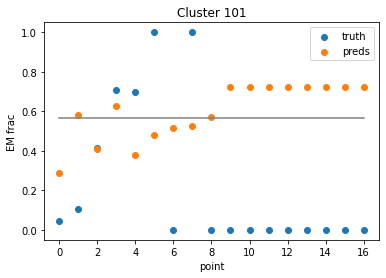

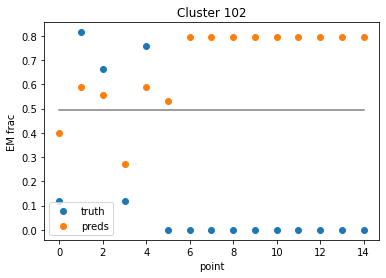

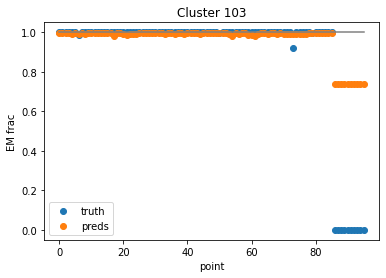

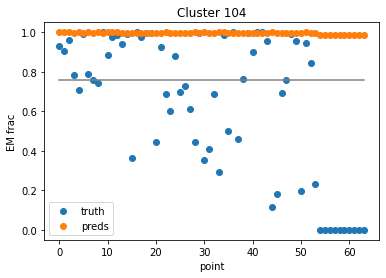

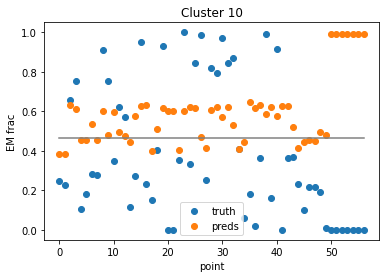

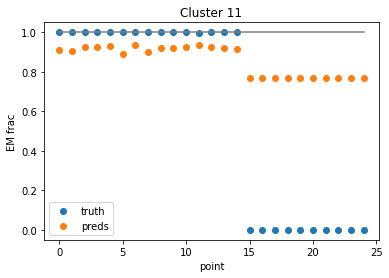

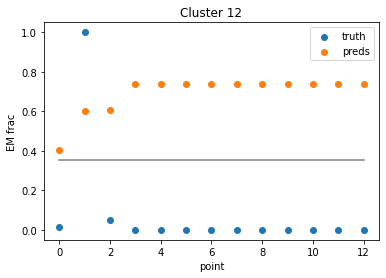

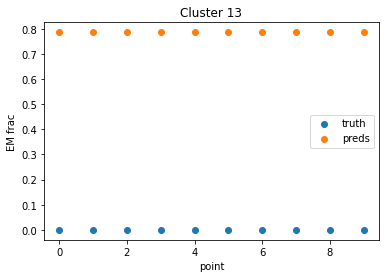

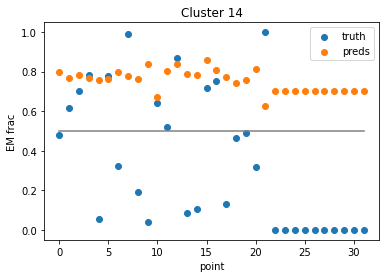

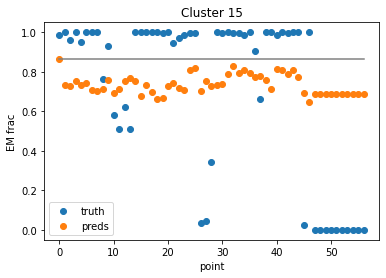

In [59]:
cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104, 10, 11, 12,13, 14,15]
for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history_subset)

In [16]:
files = ["history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/history.npz"]

for file in files:
    print(file)
    history = get_history(file)
    preds = history["preds"][:9000] # 10 s
    print("got preds")   
    labels = history["labels"][:9000]
    print("got labels")    
    #print(history["preds"].shape) # takes 3m to get shape ??

    plot_epoch_loss(history["history"].item())
    #cluster_idxs = [0, 1, 2, 3, 4, 100, 101, 102, 103, 104]
    history_subset = {
        "preds": preds,
        "labels": labels,
    }
    print("mse (all points):", mse_batch(history_subset["preds"], history_subset["labels"]))
    print("mse (no pad):", mse_batch_no_pad(history_subset["preds"], history_subset["labels"]))

    plot_batch_loss(history["loss"])
    for cluster_idx in cluster_idxs:
        plot_clus_pred_acc(cluster_idx, history_subset)

    plot_all_clus_acc(history_subset)

labels = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/labels.npy")
for i in range(5):
    preds = np.load("/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/preds_" + str(i) + ".npy")
    print(mse_batch_no_pad(preds, labels))
    plot_clus_pred_acc(1, {"preds": preds, "labels": labels})

history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test/history.npz
got preds
got labels


TypeError: plot_epoch_loss() missing 1 required positional argument: 'val_loss'

: 

In [73]:
# test splitting epochs
from numpy import genfromtxt
my_data = genfromtxt('/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test_history_log.csv', delimiter=',')
print(my_data[1:])

[[0.         0.00589739 0.0056705 ]
 [1.         0.00524507 0.00503456]
 [2.         0.00507276 0.00519241]
 [3.         0.00501483 0.00496156]
 [4.         0.00501441 0.00504926]]


together
epoch 0
0.11962304623999713


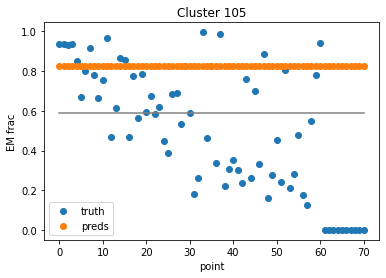

epoch 1
0.10939116132544768


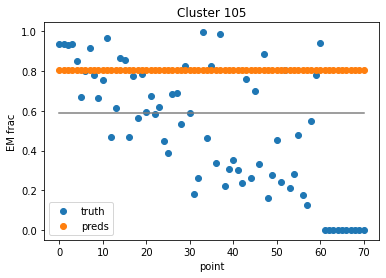

epoch 2
0.11090285163697304


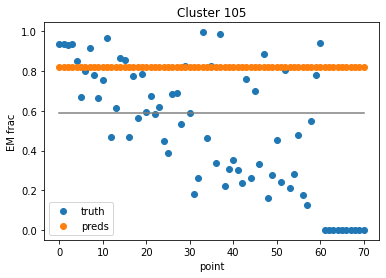

epoch 3
0.11047728800166419


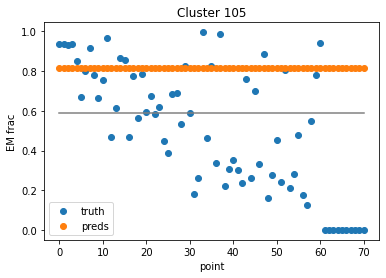

epoch 4
0.11121767593704333


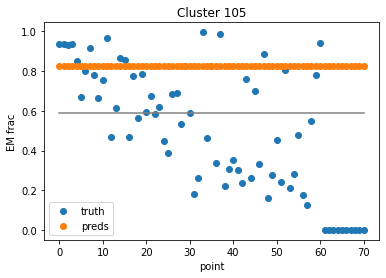

separate
epoch 0
0.11893601016780228


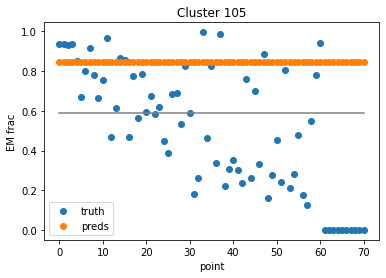

epoch 1
0.12120417830387034


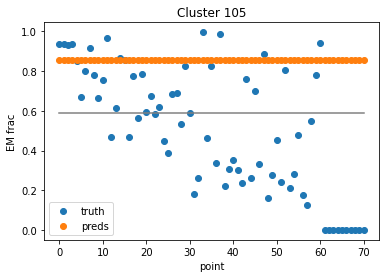

epoch 2
0.10952059618627158


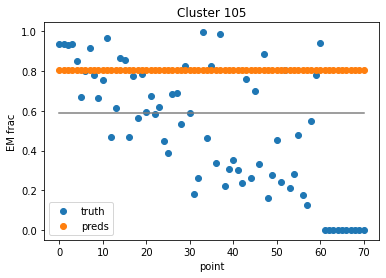

epoch 3
0.10801988317820205


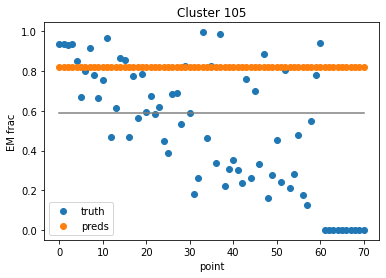

epoch 4
0.11620911227291698


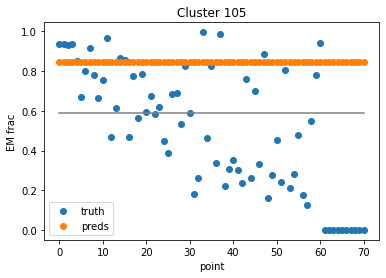

In [13]:
# test splitting epochs
for key_word in ["together", "separate"]:
    print(key_word)
    file_name = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test_" + key_word
    history = np.load(file_name + "/")
    labels = np.load(file_name +"/tests/labels.npy")
    for i in range(5):
        print("epoch", i)
        preds = np.load(file_name +"/tests/preds_" + str(i) + ".npy")
        print(mse_batch_no_pad(preds, labels))
        plot_clus_pred_acc(105, {"preds": preds, "labels": labels})

{'loss': [0.005729405340182449, 0.005239354213147967, 0.005041854307651343, 0.004975900637158038, 0.004979449487070584], 'val_loss': [0.005374639966421657, 0.005105283805065685, 0.005037969842553139, 0.004899546773897277, 0.004890883165929052]}


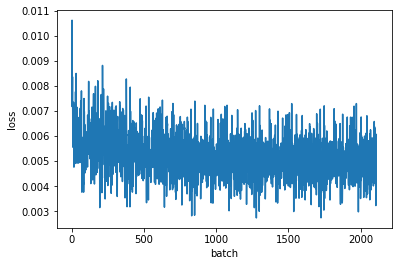

ValueError: could not broadcast input array from shape (1266,) into shape (0,)

In [152]:
# test splitting epochs
file_name = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/history_gamma_1_tr_1_tst_1_val_5_epoch_BN_cartesian_test_"
history = np.load(file_name + "together/history_epochs_0_to_5.npz", allow_pickle=True)
print(history["history"])
plot_batch_loss(history["loss"])

history1 = np.load(file_name + "separate/history_epochs_0_to_1.npz", allow_pickle=True)

history2 = np.load(file_name + "separate/history_epochs_1_to_4.npz", allow_pickle=True)

history3 = np.load(file_name + "separate/history_epochs_4_to_5.npz", allow_pickle=True)

loss = np.zeros(len(history1["loss"])+len(history2["loss"])+len(history3["loss"]))
loss[:len(history1["loss"])] = history1["loss"]
loss[len(history1["loss"]):len(history1["loss"])] = history2["loss"]
#loss[-len(history3["loss"]):] = history3["loss"]

plot_batch_loss(loss)

In [245]:
# load all train data
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/gamma_325_tr_40_tst_40_val_50_epoch_BN_cartesian' 
loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
loss = loss_data[1]
val_loss = loss_data[2]

num_epochs = 4
preds = []
mse_batch_loss = []
pointwise_loss = []
labels = np.load(dir + "/tests/labels.npy")
for epoch in range(num_epochs):
    preds.append(np.load(dir + "/tests/preds_" + str(epoch) + ".npy"))
    mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))
    pointwise_loss.append(pointwise_loss_func(labels, preds[epoch]))
    #loss1.append(loss_func(labels, preds[epoch]))
    #loss2.append(loss_func2(labels, preds[epoch]))

# takes ~2.5 min

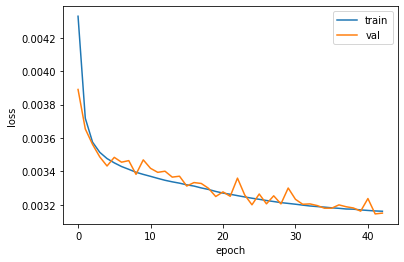

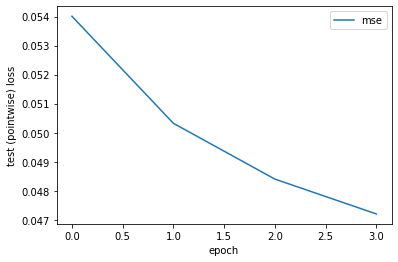

test (batchwise) [0.090201822604436, 0.07708287173462755, 0.07482004444124078, 0.07289525812081982]
test (pointwsie) [0.054009617701636786, 0.05032360874836521, 0.04840258200765468, 0.0472025466106312]


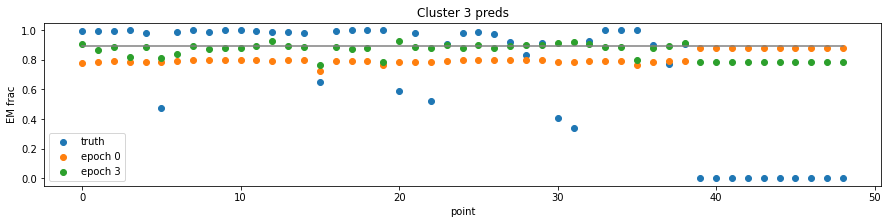

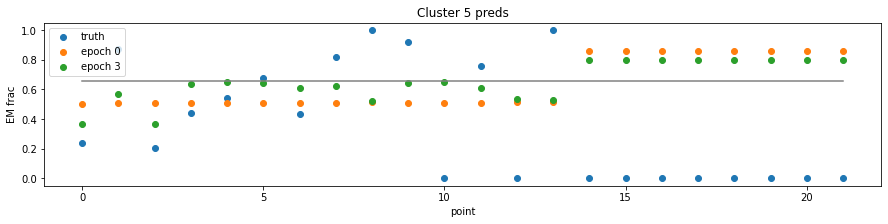

<Figure size 432x288 with 0 Axes>

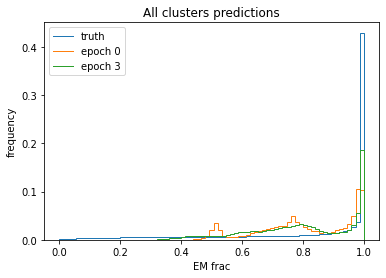

In [246]:
# plot train and val loss
plot_epoch_loss(loss, val_loss)

# plot manually computed mse batch loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(pointwise_loss, label="mse")
plt.xlabel("epoch")
plt.ylabel("test (pointwise) loss")
plt.legend()
plt.show()
#print("test mse (epoch 0):", mse_batch_loss[0])
#print("test mse (epoch 21):", mse_batch_loss[21])
print("test (batchwise)", mse_batch_loss)
print("test (pointwsie)", pointwise_loss)
# plot clusters preds/labels over epochs
epochs = [0,3]
clusters = [3,5]
separate = True

plot_clus_preds_acc(clusters, preds, labels, epochs)

LOSS DEBUG

In [232]:
#labels = np.load(dir + "/tests/labels.npy") # labels is being modified !!!

print(np.mean(np.mean(np.square(labels - preds[0]), axis=1)))
print(np.mean(np.square(labels - preds[0]), axis=None))

mask = (labels == 0)
print(mask)
masked_preds = np.copy(preds[0])
masked_preds[mask] = np.NaN
print(masked_preds)
print(np.square(labels - masked_preds))
print(np.nanmean(np.square(labels - masked_preds), axis=1)[:5])
print(np.nanmean(np.nanmean(np.square(labels - masked_preds), axis=1)))


print(np.mean(np.square(labels[labels != 0] - preds[0][labels != 0])))
print(mse_batch_no_pad(preds[0], labels))




0.4041985850884529
0.40419858508845297
[[[False]
  [ True]
  [ True]
  [ True]
  [ True]]

 [[False]
  [False]
  [False]
  [False]
  [False]]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [149]:
# how many of the clusters are empty?
cut_zeros = (labels == 0)
labels[~cut_zeros] = 1


print(np.count_nonzero(np.sum(labels, axis=1) == 0)) # in 9000 clusters ~ 450 are empty AH

450


(9472, 935, 1)
mse: 0.6697162552165918
empty: 501
mse(no pad): 0.10690015339039437
mse (no pad & flatten): 0.07668699328448154
mse (flatten): 0.6697162552165918
{'loss': [346.49301699374587], 'val_loss': [315.5167454427083]}


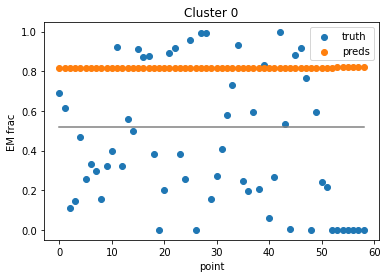

In [12]:
dir = "/fast_scratch_1/jbohm/train_testing_data/pointnet_train_1/gamma_1_tr_1_tst_1_val_1_epoch_BN_cartesian_test_loss/"
labels = np.load(dir + "tests/labels_5_files.npy")
preds = np.load(dir + "tests/preds_5_files_0.npy")

print(labels.shape)
print("mse:", mse_batch(labels, preds))
print("mse(no pad):", mse_batch_no_pad(preds, labels))
print("mse (no pad & flatten):", np.mean(np.square(preds[labels!=0] - labels[labels!=0]), axis=None))
print("mse (flatten):", np.mean(np.square(preds - labels), axis=None))
history = get_history("gamma_1_tr_1_tst_1_val_1_epoch_BN_cartesian_test_loss/history_epochs_0_to_1.npz")
print(history["history"])
plot_clus_pred_acc(0, preds, labels)

In [183]:
sum_num_unmasked = 0
count = 0
for i, clus_labels in enumerate(labels):
    cut_padding = (clus_labels != 0)
    sum_num_unmasked += len(clus_labels[cut_padding] != 0)
    count += 1
print("avg unmasked = ", sum_num_unmasked/(count - 455)) # 455 empty clusters

avg unmasked =  58.702900895071714


In [11]:
sum_unmasked = 0
sum_masked = 0
count_unmasked = 0
count_masked = 0
sum_all = 0
count = 0

for clus_idx, clus_labels in enumerate(labels):
    cut_padding = (clus_labels != 0)
    if(len(clus_labels[cut_padding]) != 0):
        count_unmasked += len(clus_labels[cut_padding])
        sum_unmasked += np.mean(np.square(clus_labels[cut_padding] - preds[clus_idx][cut_padding]))
    if(len(clus_labels[~cut_padding]) != 0):
        sum_masked += np.mean(np.square(clus_labels[~cut_padding] - preds[clus_idx][~cut_padding]))
        count_masked += len(clus_labels[~cut_padding])
    if(len(clus_labels) != 0):  
        sum_all += np.mean(np.square(clus_labels - preds[clus_idx]))
    if(len(clus_labels) == 0):
        print("empty", clus_labels)
    count += 1

print("mse unmasked:", sum_unmasked/count)
print("mse masked:", sum_masked/count)
print("mse:", sum_all/count)
print("avg num unmasked:", count_unmasked/count)
print("avg num masked:", count_masked/count)


mse unmasked: 0.10729640294971866
mse masked: 0.7202840811513436
mse: 0.6798138661739279
avg num unmasked: 56.229201858108105
avg num masked: 878.7707981418919


TRAIN 2

In [31]:
def train_summary_stats(file_name, num_epochs, clusters=[], batch_loss=False):
    # load all train data
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name 
    loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]

    preds = []
    mse_batch_loss = []
    pointwise_loss = []
    labels = np.load(dir + "/tests/labels_5_files.npy")
    for epoch in range(num_epochs):
        preds.append(np.load(dir + "/tests/preds_5_files_" + str(epoch) + ".npy"))
        mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))
        pointwise_loss.append(pointwise_loss_func(labels, preds[epoch]))

    # plot train and val loss
    plot_epoch_loss(loss, val_loss)

    # plot manually computed mse batch loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(mse_batch_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

    # plot manually computed mse batch loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(mse_batch_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

    print("test (batchwise)", mse_batch_loss)
    print("test (pointwise)", pointwise_loss)

    # plot clusters preds/labels over epochs
    epochs = [0]
    if num_epochs != 1:
        epochs.append(num_epochs - 1)

    plot_clus_preds_acc(clusters, preds, labels, epochs)

    if batch_loss:
        loss = np.load(dir + "/history_epochs_0_to_1.npz", allow_pickle=True)["batch_end_loss"].item()
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.plot(loss)
        plt.xlabel("epoch")
        plt.ylabel("batch loss")
        plt.show()


In [ ]:
def plot_preds_vs_truth(file_name, epoch):
    dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name

    preds = np.load(dir + "/tests/preds_5_files_" + str(epoch) + ".npy")
    labels = np.load(dir + "/tests/labels_5_files.npy")
    cut_unmasked = labels != MASK_OUT

    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    plt.hist2d(labels[cut_unmasked], preds[cut_unmasked], (50,50), norm=mpl.colors.LogNorm() cmap=plt.cm.BuPu)
    plt.xlabel("EM frac truth")
    plt.ylabel("EM frac pred")
    plt.colorbar(label="frequency")
    plt.show()

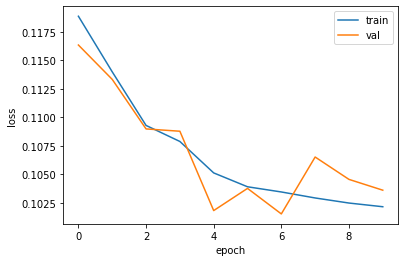

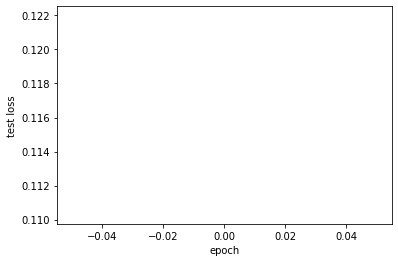

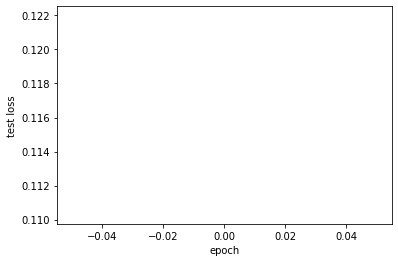

test (batchwise) [0.1161432920787593]
test (pointwise) [0.07999429162770563]


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

In [30]:
train_summary_stats("_2/gamma_23_tr_4_tst_4_val_10_epoch_BN_cartesian", 1)

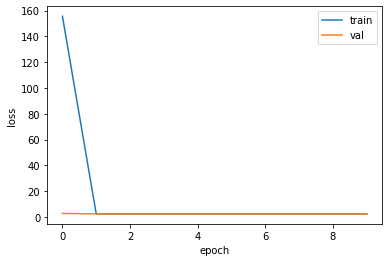

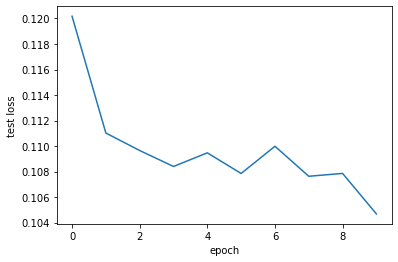

test [0.12017450109645986, 0.11102235495458145, 0.10965383871586866, 0.10840233633617784, 0.1094709593008103, 0.10785371488409705, 0.10998664554570137, 0.10763464610354558, 0.10785676267535783, 0.10468431582119357]


<Figure size 432x288 with 0 Axes>

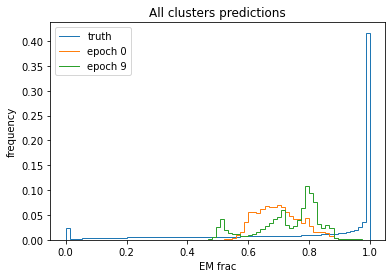

In [134]:
train_summary_stats("_2/gamma_23_tr_4_tst_4_val_1_epoch_BN_cartesian_activity_regularizer", 10)

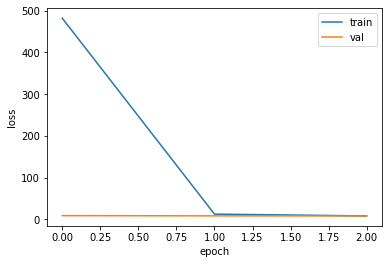

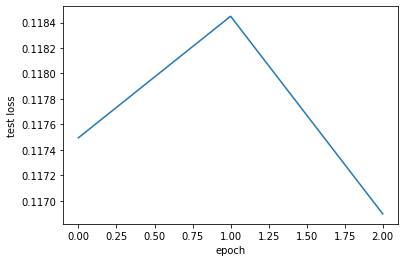

test [0.11749427681670467, 0.1184493692424006, 0.11689592410918277]


<Figure size 432x288 with 0 Axes>

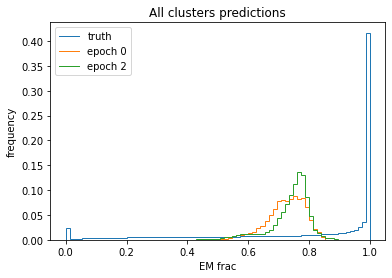

In [141]:
train_summary_stats("_2/part_seg_23_tr_4_tst_4_val_1_epoch_BN_cartesian", 3)

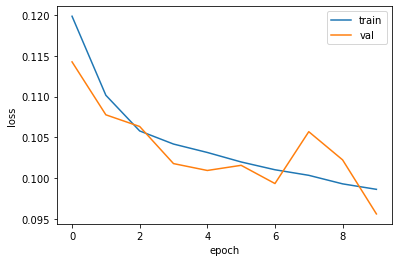

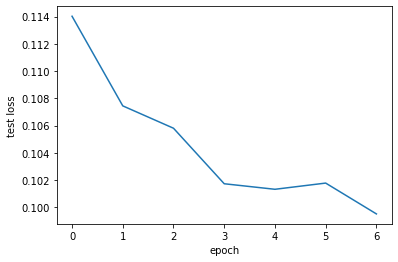

test [0.11402892049913689, 0.10744678161326819, 0.10580500977034565, 0.10172765737694774, 0.10132097720840388, 0.10177694353855857, 0.09951222012347201]


<Figure size 432x288 with 0 Axes>

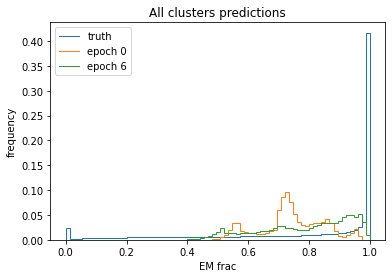

In [175]:
train_summary_stats("_2/gamma_23_tr_4_tst_4_val_10_epoch_BN_cartesian_stack_output", 4)

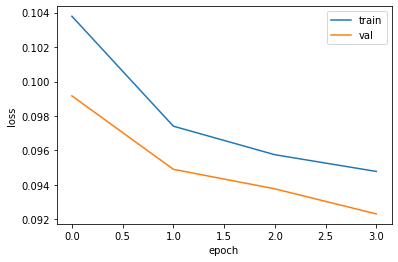

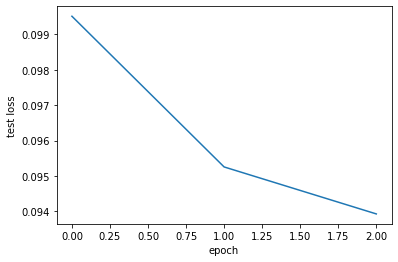

test [0.09951063810153697, 0.09525459870905256, 0.09392759873172032]
test (pointwise) [0.06734086479094124, 0.06279423610509487, 0.062031494067887244]


<Figure size 432x288 with 0 Axes>

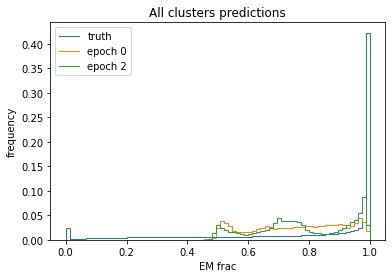

In [259]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian", 8)

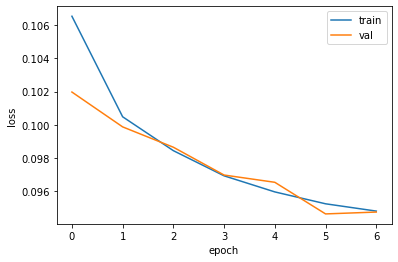

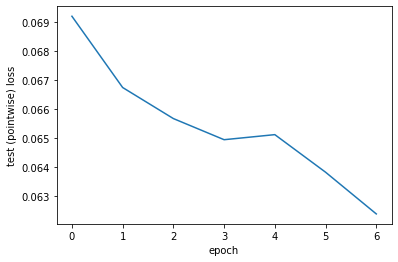

test [0.10224455353472209, 0.10007314821118021, 0.09890738622948447, 0.09711093941515743, 0.09670386905930235, 0.09503576910091315, 0.09519901419842451]


<Figure size 432x288 with 0 Axes>

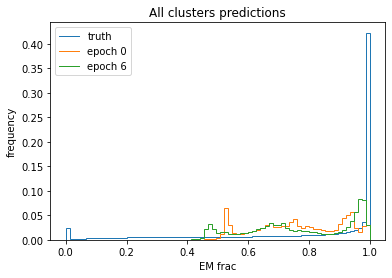

In [232]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian_stack_output", 7)


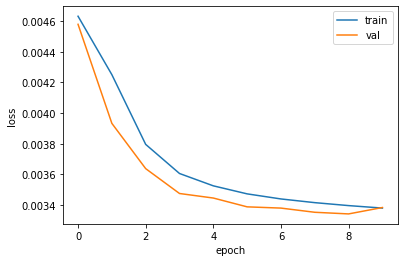

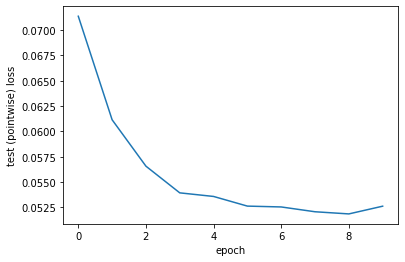

test [0.10651732233512015, 0.09862254869175618, 0.08851475341725878, 0.08258287408998317, 0.08276068948105049, 0.08065714835227598, 0.0807665399567511, 0.07989997516305032, 0.08054643906759802, 0.08200316458683303]


<Figure size 432x288 with 0 Axes>

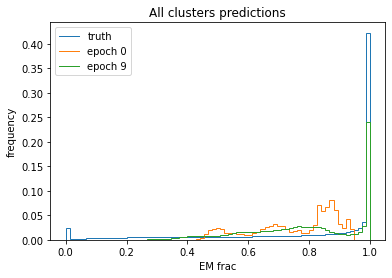

In [233]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian_weight_points_equal", 10)

In [4]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian_stacked_output_weight_points_equal", 12)

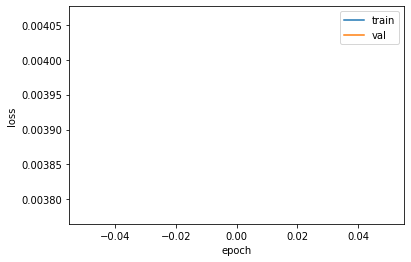

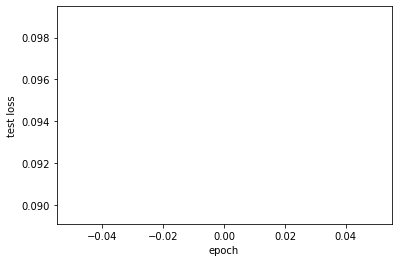

test [0.09429914060999058]
test (pointwise) [0.05873886197352382]


<Figure size 432x288 with 0 Axes>

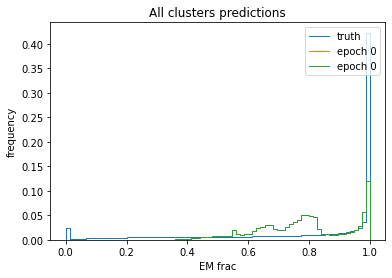

In [351]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_lawrence_stacked_output_weight_points_equal", 1)

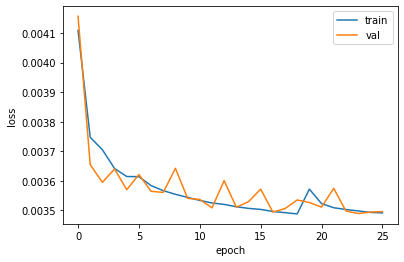

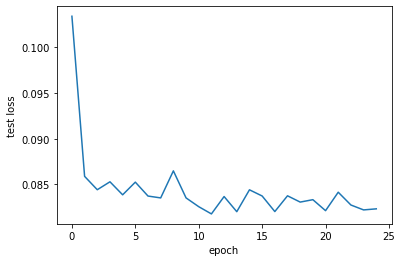

test [0.10340385466488879, 0.08589023090531232, 0.08442734161279111, 0.0852947083922177, 0.08387084828811987, 0.08525669009368665, 0.08373539953323376, 0.08353153633814625, 0.08649074851005839, 0.08353254096120036, 0.08257185638554894, 0.0817810535966257, 0.08368116672159046, 0.08202477057164614, 0.08441849819550115, 0.08374145239639874, 0.08203868751829894, 0.08376239371999213, 0.08307518255293302, 0.0833380507937931, 0.08213656902099299, 0.08415502396063258, 0.08275511112289471, 0.08221888448192871, 0.08233596426099517]
test (pointwise) [0.06445424111002784, 0.056832491400519415, 0.05591326794460432, 0.05662954766570619, 0.05543797697516853, 0.056346840036060296, 0.055483045227306106, 0.05525665402556838, 0.056660159062010496, 0.055063193737305144, 0.054949814409096825, 0.05463476059058762, 0.05599026443893117, 0.05461710648478436, 0.05483986722563817, 0.055488565405154136, 0.05427031744063078, 0.05450177807623975, 0.05501189281354272, 0.05490063534668766, 0.054606357309597196, 0.055

<Figure size 432x288 with 0 Axes>

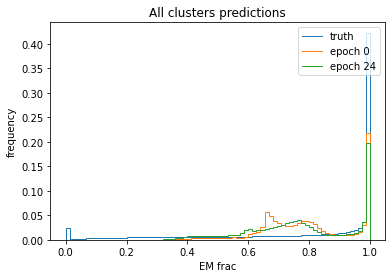

In [305]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_spherical_stacked_output_weight_points_equal", 25)

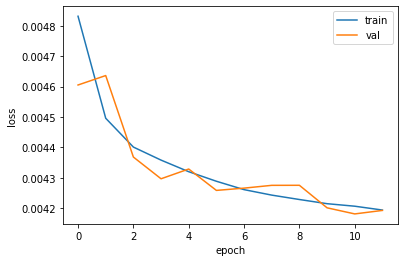

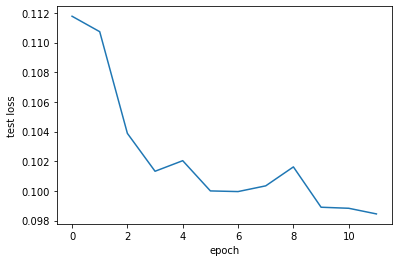

test [0.11178170023361912, 0.11073960110782358, 0.10387928019057116, 0.10132414335702254, 0.10203767245292975, 0.0999978801333921, 0.09995377837686055, 0.10034020719611468, 0.10161837887153778, 0.09889774936718046, 0.09882704654846848, 0.09844659833715773]
test (pointwise) [0.08054743826101478, 0.08131407341146622, 0.0765235428186863, 0.07526602834238721, 0.07581696021159064, 0.07472942069700729, 0.07473116689188994, 0.07492014493434526, 0.07513412795749369, 0.07358925207870465, 0.07328847372812404, 0.07347413305381553]


<Figure size 432x288 with 0 Axes>

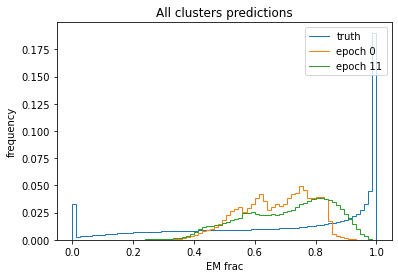

In [6]:
train_summary_stats("_3/gamma_charged_325_tr_40_tst_38_val_BN_cartesian_stacked_output_weight_points_equal", 12)


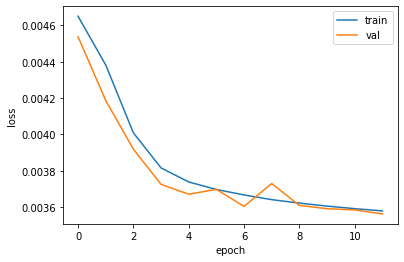

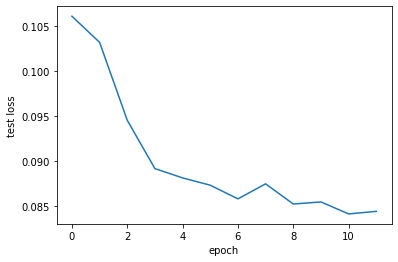

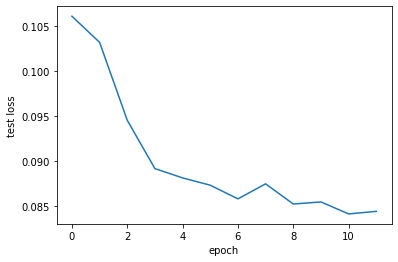

test (batchwise) [0.10606024136082164, 0.10316088348557746, 0.0945099441350568, 0.08914739180449832, 0.0881159365264069, 0.08730497984772503, 0.08578830678408374, 0.08745637938695085, 0.08521681251531257, 0.08544808016342699, 0.08411787628085324, 0.0844028407037173]
test (pointwise) [0.0708604182599762, 0.0651603437735305, 0.06089750618119919, 0.057833093305513186, 0.057031504863203304, 0.05743628714572115, 0.05596493653127146, 0.0579291524307751, 0.05601614352473052, 0.05586206065283536, 0.055697761756739024, 0.05533825710665256]


In [5]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_BN_cartesian_stacked_output_weight_points_equal_zero_pad", 12)

In [ ]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_BN_cartesian_stacked_output_weight_points_equal_zero_pad", 3)

In [9]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_BN_cartesian_stacked_output_weight_points_equal_zero_pad_no_tnet", 16)


FileNotFoundError: [Errno 2] No such file or directory: '/fast_scratch_1/jbohm/train_testing_data/pointnet_train_2/gamma_325_tr_40_tst_40_val_BN_cartesian_stacked_output_weight_points_equal_zero_pad_no_tnet/tests/preds_5_files_17.npy'

Batch normalize analysis

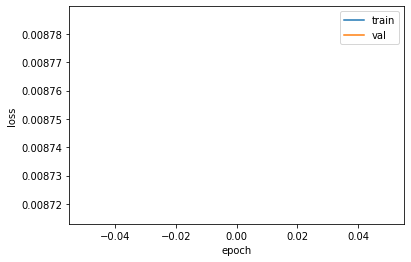

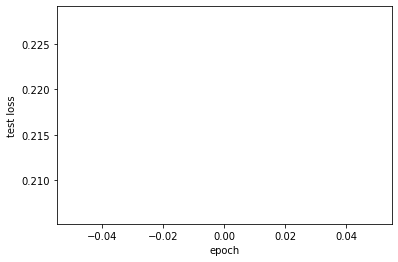

test [0.2171716524950901]
test (pointwise) [0.13547117005517803]


<Figure size 432x288 with 0 Axes>

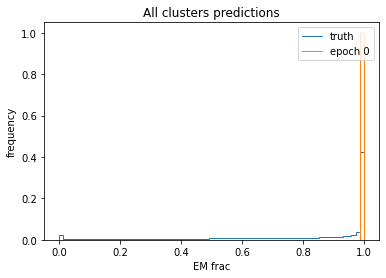

KeyError: 'batch_end_loss is not a file in the archive'

In [5]:
train_summary_stats("_2/gamma_50_tr_5_tst_10_val_cartesian_stacked_output_weight_points_equal_no_BN", 1)

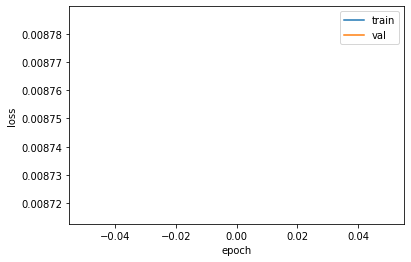

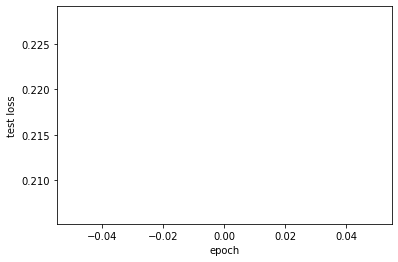

test [0.2171716524950901]
test (pointwise) [0.13547117005517803]


<Figure size 432x288 with 0 Axes>

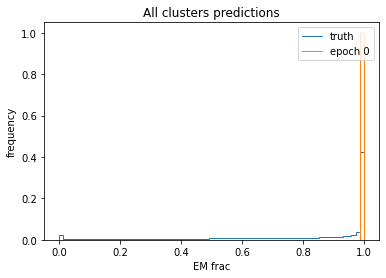

In [4]:
train_summary_stats("_2/gamma_50_tr_5_tst_10_val_cartesian_stacked_output_weight_points_equal_pre_BN", 1)

In [23]:
train_summary_stats("_2/gamma_325_tr_40_tst_40_val_BN_cartesian_stacked_output_weight_points_equal_zero_pad_no_tnet'", 9)

FileNotFoundError: /fast_scratch_1/jbohm/train_testing_data/pointnet_train_2/gamma_325_tr_40_tst_40_val_BN_cartesian_stacked_output_weight_points_equal_zero_pad_no_tnet'/log_loss.csv not found.

In [ ]:
train_summary_stats("_2/gamma_50_tr_5_tst_10_val_cartesian_stacked_output_weight_points_equal_BN_layers_zero_pad", 1)

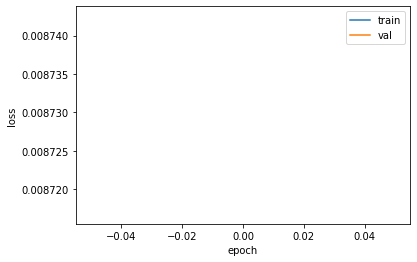

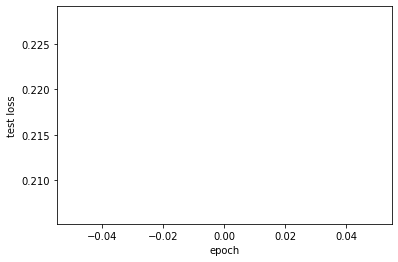

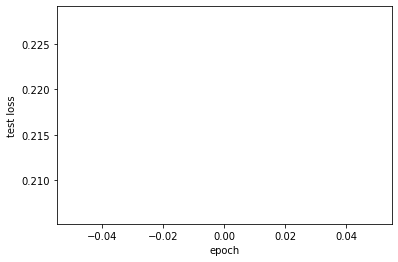

test (batchwise) [0.2171716524950901]
test (pointwise) [0.13547117005517803]


<Figure size 432x288 with 0 Axes>

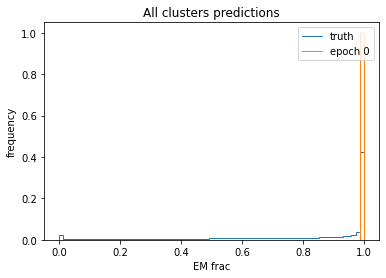

In [32]:
train_summary_stats("_2/gamma_100_tr_5_tst_15_val_cartesian_stacked_output_weight_points_equal_log_E", 1)


In [285]:
num_epochs = 5
file_name = "_2/gamma_325_tr_40_tst_40_val_10_epoch_BN_cartesian_weight_points_equal"
dir = '/fast_scratch_1/jbohm/train_testing_data/pointnet_train' + file_name 
loss_data = genfromtxt(dir + "/log_loss.csv", delimiter=',').transpose()
loss = loss_data[1]
val_loss = loss_data[2]

preds = []
mse_batch_loss = []
labels = np.load(dir + "/tests/labels_5_files.npy")
for epoch in range(num_epochs):
    preds.append(np.load(dir + "/tests/preds_5_files_" + str(epoch) + ".npy"))
    mse_batch_loss.append(mse_batch_no_pad(preds[epoch], labels))


In [366]:
# Leading cells EM frac plotting functions
def plot_leading_cells_energy(cell_nums, preds, labels, bins=100):
    cut_padding = (labels != MASK_OUT)
    for cell_num in cell_nums:
        labels_cut = labels[:, cell_num, :][cut_padding[:, cell_num, :]]
        preds_cut = preds[:, cell_num, :][cut_padding[:, cell_num, :]]
        pu.plot_overlay_hist([labels_cut, preds_cut], bins, "Leading cells " + str(cell_num), "EM frac", "frequency", ["truth", "preds"])

def plot_leading_cells_energy_frac(cell_nums, preds, labels, bins=100, frac=2):
    cut_padding = (labels != MASK_OUT)
    for cell_num in cell_nums:
        labels_cut = labels[:, cell_num, :][cut_padding[:, cell_num, :]]
        preds_cut = preds[:, cell_num, :][cut_padding[:, cell_num, :]]

        labels_counts, bins = np.histogram(labels_cut, bins)
        preds_counts, bins = np.histogram(preds_cut, bins)
        # np.histogram return bin edges (len = bin values + 1), and bin values
        

        # normalize counts
        labels_counts = labels_counts / np.sum(labels_counts)
        preds_counts = preds_counts / np.sum(preds_counts)

        if frac == 1:
            # measure of simularity:
            #   2 - pred_counts/truth_counts, if pred_counts > truth_counts
            #   truth_counts / pred_counts, otherwise
            true_pred_frac = [2 - preds_counts[i]/labels_counts[i] if labels_counts[i] > preds_counts[i] else labels_counts[i]/preds_counts[i] for i in range(len(labels_counts))]
            true_pred_frac = np.nan_to_num(true_pred_frac, nan=1)

            fig = plt.figure(figsize=(6,1.5))
            fig.patch.set_facecolor('white')
            plt.step(bins[:-1], true_pred_frac, where="pre")
            plt.fill_between(bins[:-1],true_pred_frac, y2=1, step="pre", alpha=0.4)
            plt.plot(bins, np.repeat(1, len(bins)), color="grey")
            plt.ylim((0, 2.25))
            plt.ylabel("truth/pred ratio")


            
        if frac == 2:
            # use a scaled distance metric
            #  (truth_counts - pred_counts) / (truth_counts + pred_counts)
            true_pred_frac = [(labels_counts[i] - preds_counts[i])/(labels_counts[i] + preds_counts[i] if labels_counts[i] + preds_counts[i] > 0 else 1) for i in range(len(labels_counts))]

            fig = plt.figure(figsize=(6,1.5))
            fig.patch.set_facecolor('white')
            plt.step(bins[:-1], true_pred_frac, where="pre")
            plt.fill_between(bins[:-1],true_pred_frac, y2=0, step="pre", alpha=0.4)
            plt.plot(bins, np.repeat(0, len(bins)), color="grey")
            plt.ylabel("(true-pred)/(true+pred)")


        
        plt.title("Leading cells " + str(cell_num))
        plt.xlabel("EM frac")
        plt.show()



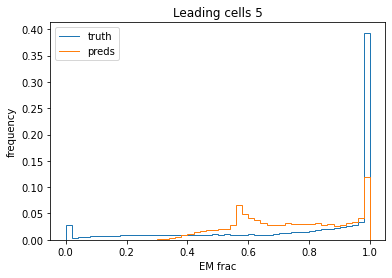

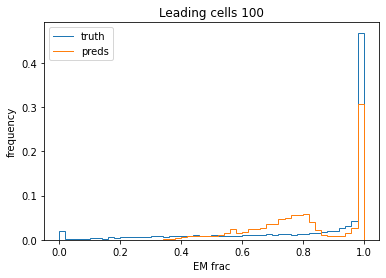

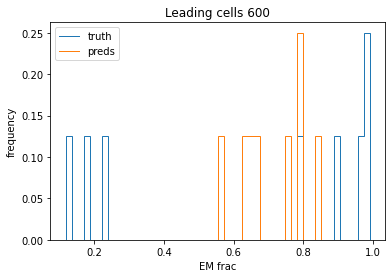

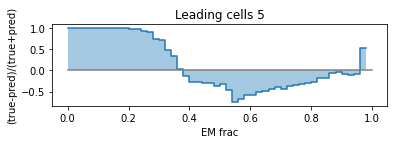

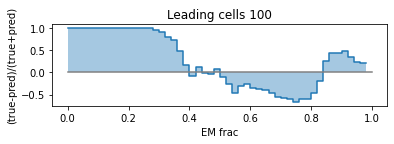

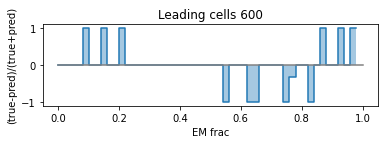

In [367]:
leading_cell_nums = [5, 100, 600]#, 1, 2, 3, 4, 5, 100, 200, 300, 400, 500, 934]

plot_leading_cells_energy(leading_cell_nums, preds[3], labels, 50)
plot_leading_cells_energy_frac(leading_cell_nums, preds[3], labels, 50)